# Create and pair agents
Create noised version of the reference matrix and pair up individual agents.

In [11]:
import glob
from animal_game.utils import compute_thresholds
from animal_game.agents import Agent
import itertools
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import random
from multiprocessing import Pool

In [12]:
models = ['animal_game/models/wiki_euclidean_distance.tsv']
animals = pd.read_csv('animal_game/models/animal_list.csv')
thresholds = compute_thresholds(models, 
                                q=[round(n,2) for n in np.arange(0.05, 1.0, 0.05)], 
                                round_at=5)

### Generate noised matrices

Read in the vectors

In [13]:
X = pd.read_csv('animal_game/models/wiki_vectors.tsv', 
                sep='\t', header=None, index_col=0)
X_scaled = MinMaxScaler().fit_transform(X.values)

In [14]:
date = '21_05_27'
nr_agents_per_nl = 100
noise_levels = [round(r,2) for r in np.arange(0.01, 0.1, 0.02)]

In [15]:
eudist_mats = [] # distance matrices
mats = [] # vectors matrics
for idx in range(nr_agents_per_nl):
    for nl in noise_levels:
        noise = np.random.uniform(low=-nl, high=nl, size=X.values.shape)
        X_noised = noise + X_scaled
        X_noised = np.vectorize(lambda x: 0 if x < 0 else x)(X_noised)
        X_noised = np.vectorize(lambda x: 1 if x > 1 else x)(X_noised)
        # Save matrix
        df = pd.DataFrame(X_noised)
        df.index = animals['Animals'].tolist()
        fname = f'wiki_{nl}_{idx}.tsv'
        df.to_csv(f'animal_game/models/{date}/noised_vectors/{fname}', 
                  sep='\t')
        mats.append((idx, nl, X_noised))
        # Save distances
        ed = euclidean_distances(X_noised, X_noised) / 400
        edf = pd.DataFrame(ed)
        edf.index = df.index
        edf.columns = edf.index
        edf.to_csv(f'animal_game/models/{date}/noised_distance_matrices/{fname}',
                   sep='\t')
        eudist_mats.append((idx, nl, ed))

## Compute all pairwise distances between agents

In [16]:
combs = list(itertools.combinations(eudist_mats, 2))
vcombs = list(itertools.combinations(mats, 2))

In [17]:
def _compute_distance(c):
    distance = np.sqrt(np.sum(np.square(c[0][2] - c[1][2])))
    noise_level1 = c[0][1]
    noise_level2 = c[1][1]
    idx1 = c[0][0]
    idx2 = c[1][0]
    return (idx1, idx2,
            noise_level1, noise_level2,
            distance)

In [18]:
pool = Pool(processes=10)
results = pool.map(_compute_distance, combs)

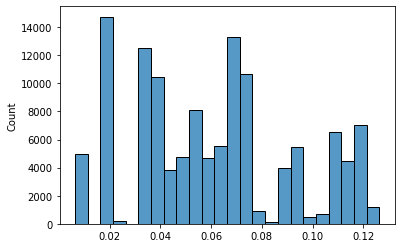

In [19]:
sns.histplot([r[-1] for r in results], binwidth=0.005)

## Sample 500 pairs with "even" distancing

In [20]:
qs = [0] + list(np.quantile([r[4] for r in results], q=[0.2, 0.4, 0.6, 0.8, 1.]))
intervals = [(qs[i], qs[i+1]) for i in range(len(qs)-1)]

In [21]:
sampled = []
for i in intervals:
    sampled += random.sample([r for r in results if (r[-1] >= i[0]) & (r[-1] < i[1])], 100)

In [22]:
distance_df = pd.DataFrame(sampled, columns=['idx1', 'idx2', 
                                             'noise_level1', 'noise_level2',
                                             'distance'])
distance_df['same_level'] = np.where(distance_df['noise_level1'] == distance_df['noise_level2'], 1, 0)

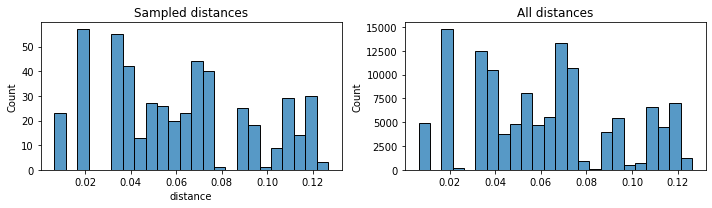

In [23]:
f, ax = plt.subplots(ncols=2, figsize=(10,3))
sns.histplot(data=distance_df, x='distance', binwidth=0.005, ax=ax[0])
ax[0].set_title('Sampled distances')
sns.histplot([r[-1] for r in results], binwidth=0.005, ax=ax[1])
ax[1].set_title('All distances')
plt.tight_layout()
plt.show()

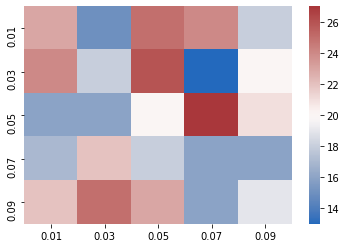

In [24]:
distance_df['noise_level1'] = distance_df['noise_level1'].round(2)
distance_df['noise_level2'] = distance_df['noise_level2'].round(2)
sns.heatmap(data=distance_df.groupby(['noise_level1', 'noise_level2'])['distance'].count().reset_index().pivot(index='noise_level1', 
                                                                                                               columns='noise_level2', 
                                                                                                               values='distance'),  
            cmap='vlag')
plt.xlabel('')
plt.ylabel('')
plt.show()

## Save selected pairs

In [25]:
distance_df.drop('same_level', axis=1, inplace=True)

In [26]:
distance_df['fname_1'] = 'wiki_' + distance_df['noise_level1'].astype(str) + '_' + distance_df['idx1'].astype(str) + '.tsv'
distance_df['fname_2'] = 'wiki_' + distance_df['noise_level2'].astype(str) + '_' + distance_df['idx2'].astype(str) + '.tsv'

In [27]:
distance_df.to_csv('animal_game/models/21_05_27/sampled_pairs.tsv', sep='\t')

In [28]:
print('Number of unique agents:')
len(set(distance_df.fname_1.unique().tolist() + distance_df.fname_2.unique().tolist()))

Number of unique agents:


423

In [29]:
from collections import Counter

In [30]:
Counter(distance_df.fname_1.unique().tolist() + distance_df.fname_2.unique().tolist())

Counter({'wiki_0.03_35.tsv': 2,
         'wiki_0.01_40.tsv': 1,
         'wiki_0.03_46.tsv': 1,
         'wiki_0.03_25.tsv': 1,
         'wiki_0.03_11.tsv': 1,
         'wiki_0.03_23.tsv': 2,
         'wiki_0.01_25.tsv': 2,
         'wiki_0.01_7.tsv': 1,
         'wiki_0.05_73.tsv': 2,
         'wiki_0.03_24.tsv': 1,
         'wiki_0.03_5.tsv': 1,
         'wiki_0.05_34.tsv': 2,
         'wiki_0.05_26.tsv': 1,
         'wiki_0.03_42.tsv': 2,
         'wiki_0.01_5.tsv': 1,
         'wiki_0.03_22.tsv': 2,
         'wiki_0.01_39.tsv': 2,
         'wiki_0.01_3.tsv': 1,
         'wiki_0.01_8.tsv': 2,
         'wiki_0.03_47.tsv': 2,
         'wiki_0.05_18.tsv': 1,
         'wiki_0.05_17.tsv': 1,
         'wiki_0.03_29.tsv': 1,
         'wiki_0.03_61.tsv': 2,
         'wiki_0.03_43.tsv': 1,
         'wiki_0.01_14.tsv': 2,
         'wiki_0.05_59.tsv': 2,
         'wiki_0.01_2.tsv': 1,
         'wiki_0.03_59.tsv': 2,
         'wiki_0.01_10.tsv': 1,
         'wiki_0.01_33.tsv': 2,
         'wiki